# Train MIL models for Head & Neck cancer patients to predict up vs. low from T1 images

In [2]:
import importlib 
import util, models, training

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)

<module 'training' from '/home/unix/hschluet/projects/pt-pbmc/training.py'>

In [3]:
from data import PlateDataset
from util import torch_random_choice
from models import GatedAttentionMulti, GatedAttention
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap


device = 'cuda:7'

In [23]:
data = PlateDataset([3, 4, 5, 6], load_masks=True, strict_discard=False, load_chrometrics=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.84s/it]


In [5]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,3,A02,0,4,P115,2,False,H&N cancer
1,3,A02,0,5,P115,2,True,H&N cancer
2,3,A02,0,6,P115,2,True,H&N cancer
3,3,A02,0,7,P115,2,False,H&N cancer
4,3,A02,0,8,P115,2,False,H&N cancer
...,...,...,...,...,...,...,...,...
461683,6,H12,9,121,P106,1,True,H&N cancer
461684,6,H12,9,124,P106,1,False,H&N cancer
461685,6,H12,9,127,P106,1,False,H&N cancer
461686,6,H12,9,134,P106,1,False,H&N cancer


In [6]:
traj = pd.read_csv('results/1_16_t01_healthy_cancer_without_plate_by_cell_mil_architecture_relaxed_trajectory_classes.csv', index_col='patient')
groups = pd.read_csv('meta/patient_diagnosis_groups.csv')
pat_info = groups.merge(traj, on='patient', how='left').set_index('patient')

local_failure = ['P16', 'P34', 'P37', 'P40', 'P51', 'P66', 'P68', 'P72', 'P74', 'P92', 'P97', 'P125', 'P132', 'P136']
distant_failure = ['P11', 'P18', 'P20', 'P34', 'P49', 'P72', 'P87', 'P91', 'P97', 'P99', 'P103', 'P125', 'P151']
dead = ['P11', 'P34', 'P51', 'P66', 'P88', 'P91', 'P97']

pat_info[['local', 'distant', 'dead']] = False
pat_info.loc[local_failure, 'local'] = True 
pat_info.loc[distant_failure, 'distant'] = True 
pat_info.loc[dead, 'dead'] = True 

pat_info

,group,trajectory,local,distant,dead
patient,,,,,
P11,Sarcoma-Rhabdomyosarcoma,NaN,False,True,True
P12,H&N cancer,NaN,False,False,False
P13,Lymphoma,low,False,False,False
P14,H&N cancer,low,False,False,False
P15,CNS-Glioma,low,False,False,False
...,...,...,...,...,...
P163,Chordoma/Chondrosarcoma,NaN,False,False,False
P164,CNS-Ependymoma,low,False,False,False
P165,Chordoma/Chondrosarcoma,high,False,False,False


In [7]:
use_plates = np.array([3, 4, 5, 6])
use_groups = ['healthy', 'H&N cancer'] 

cdf = data.info[data.info['group'].isin(use_groups)].groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H06', 'H07', 'H10', 'H22', 'H23', 'H30', 'H31', 'H37', 'H39',
       'H40', 'P100', 'P106', 'P107', 'P110', 'P114', 'P115', 'P12',
       'P120', 'P125', 'P129', 'P130', 'P135', 'P137', 'P14', 'P142',
       'P145', 'P147', 'P148', 'P149', 'P154', 'P161', 'P166', 'P18',
       'P24', 'P41', 'P44', 'P55', 'P56', 'P63', 'P67', 'P72', 'P77',
       'P78', 'P79', 'P94', 'P98'], dtype=object)

In [8]:
p1ts = traj[traj['trajectory'].isin(['up', 'low'])].index.values
p1ts = p1ts[np.isin(p1ts, p01s)]
p1ts

array(['P100', 'P107', 'P110', 'P114', 'P120', 'P130', 'P135', 'P14',
       'P142', 'P145', 'P148', 'P149', 'P18', 'P41', 'P55', 'P56', 'P63',
       'P67', 'P72', 'P77', 'P78', 'P79', 'P94', 'P98'], dtype=object)

In [10]:
groups = groups.set_index('patient')
groups

,group
patient,
P11,Sarcoma-Rhabdomyosarcoma
P12,H&N cancer
P13,Lymphoma
P14,H&N cancer
P15,CNS-Glioma
...,...
P163,Chordoma/Chondrosarcoma
P164,CNS-Ependymoma
P165,Chordoma/Chondrosarcoma


In [33]:
def up_vs_low_bagloader(bag_size=50, use_patients=p1ts, use_times=[1], use_plates=use_plates, device=device, use_groups=use_groups,  transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times) & data.info['group'].isin(use_groups)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = traj.reset_index().groupby('trajectory')['patient'].unique()
  pat_up = [p for p in pat_groups['up'] if groups.loc[p, 'group'] in use_groups and p in use_patients]
  pat_low = [p for p in pat_groups['low'] if groups.loc[p, 'group'] in use_groups and p in use_patients]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    label = np.random.randint(2)
    pat = np.random.choice(pat_up if label == 1 else pat_low)
    xs = use_data[torch_random_choice(pat_lut[pat], size=bag_size)]
    yield xs.float(), torch.tensor(label).to(device)


def test_up_vs_low_bagloader(bag_size=50, reps=11, use_patients=p1ts, use_times=[1], use_plates=use_plates, device=device, 
                             transform=T.CenterCrop(28), use_groups=use_groups, return_chrometric=False):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times) & data.info['group'].isin(use_groups)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  use_masks = transform(data.masks[use_idx].to(device))
  if return_chrometric:
    use_chrometric = data.chrometrics.iloc[use_idx].reset_index()
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any() or not groups.loc[pat, 'group'] in use_groups:
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    for _ in range(reps):
      idx = torch_random_choice(pat_idx, size=bag_size)
      xs = use_data[idx]
      t = traj.loc[pat, 'trajectory']
      label = 1 if t == 'up' else 0
      if not return_chrometric:
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t
      else: 
        yield xs.float(), use_masks[idx], torch.tensor(label).to(device), pat, t, use_chrometric.iloc[idx.cpu().numpy()]

In [12]:
pat_diag_groups = pat_info.reset_index().groupby('group')['patient'].unique()
pat_diag_groups

group
CNS-Ependymoma                           [P71, P73, P80, P82, P89, P95, P164]
CNS-Glioma                  [P15, P16, P22, P29, P46, P47, P51, P52, P57, ...
CNS-Medulloblastoma                     [P19, P30, P35, P53, P54, P158, P167]
CNS-Meningioma              [P27, P33, P37, P38, P42, P48, P59, P62, P70, ...
CNS-other                   [P20, P28, P60, P66, P75, P87, P91, P96, P111,...
Chordoma/Chondrosarcoma     [P21, P23, P25, P43, P69, P76, P90, P92, P99, ...
H&N cancer                  [P12, P14, P18, P24, P41, P44, P50, P55, P56, ...
Lymphoma                                 [P13, P17, P32, P36, P58, P65, P109]
Sarcoma-Ewing                    [P26, P34, P85, P97, P103, P140, P146, P159]
Sarcoma-Neuroblastoma                                              [P49, P61]
Sarcoma-Rhabdomyosarcoma                               [P11, P74, P139, P151]
Sarcoma-other                                               [P45, P117, P136]
Name: patient, dtype: object

In [21]:
def eval_model(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    for i, (bag, mask, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    return df, bag_zs, bags, masks


def eval_model_with_chrometric(classifier_name, loader, branches=5, classes=1):
    if classes > 1:
      classifier = GatedAttentionMulti(classes=classes, branches=branches)
    else:
      classifier = GatedAttention(branches=branches)
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{classifier_name}_model.pt', weights_only=True, map_location=device))
    classifier.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_attn = []
    bag_rattn = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    masks = []
    chrometrics = []
    for i, (bag, mask, lab, pat, group, cs) in enumerate(loader):
        with torch.no_grad():
            _, pred, attn, rattn, z = classifier(bag.to(device))
        bag_ids.extend([i] * 50)
        bag_pats.extend([pat] * 50)
        bag_groups.extend([group] * 50)
        bag_labs.extend([lab.item()] * 50)
        bag_pred.extend([pred.cpu().item()] * 50)
        if branches == 1:
            bag_attn.extend(attn.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.cpu().squeeze().numpy())
        else:
            bag_attn.extend(attn.T.cpu().squeeze().numpy())
            bag_rattn.extend(rattn.T.cpu().squeeze().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())
        masks.extend(mask.cpu().numpy())
        chrometrics.append(cs)

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    if branches == 1:
        df['attention'] = bag_attn
        df['raw attention'] = bag_rattn
    else:
        df[[f'attention {i}' for i in range(branches)]] = bag_attn
        df[[f'raw attention {i}' for i in range(branches)]] = bag_rattn
    chrometrics = pd.concat(chrometrics, ignore_index=True)
    return df, bag_zs, bags, masks, chrometrics

In [14]:
group = 'H&N cancer'
g_pats = p1ts[np.isin(p1ts, pat_diag_groups[group])]
g_pats

array(['P100', 'P107', 'P110', 'P114', 'P120', 'P130', 'P135', 'P14',
       'P142', 'P145', 'P148', 'P149', 'P18', 'P41', 'P55', 'P56', 'P63',
       'P67', 'P72', 'P77', 'P78', 'P79', 'P94', 'P98'], dtype=object)

## Leave one out

In [93]:
dfs = []

for p in g_pats:
    name = f'3_6_traj_without_{p}'
    train_loader = up_vs_low_bagloader(use_groups=[group], use_patients=p1ts[p1ts != p])
    classifier = GatedAttention(branches=5)
    _ = train_model(classifier, bag_loader=train_loader, 
                    num_iter=20_000, lr=0.0001, device=device, fname=name, 
                    save_model=True, seed=12341, plot=False,
                    transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))
    test_loader = test_up_vs_low_bagloader(use_groups=[group], use_patients=[p])
    df, _, _, _ = eval_model(name, test_loader) 
    dfs.append(df)
    print(p, (df['pred'] == df['lab']).mean())


eval_df = pd.concat(dfs)
eval_df

  0%|                                                                                                                                                                                       | 0/20000 [00:00<?, ?it/s]

iter: 19999; train loss: 2.34984064; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 241.90it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P100_model.pt
P100 0.6363636363636364


iter: 19999; train loss: 0.08517671; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P107_model.pt
P107 1.0


iter: 19999; train loss: 0.08499059; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 241.73it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P110_model.pt
P110 0.0


iter: 19999; train loss: 1.88513970; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:24<00:00, 236.37it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P114_model.pt
P114 0.9090909090909091


iter: 19999; train loss: 1.80107188; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 239.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P120_model.pt
P120 0.0


iter: 19999; train loss: 1.62542260; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 241.30it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P130_model.pt
P130 0.0


iter: 19999; train loss: 1.74933863; train error: 1.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:24<00:00, 237.84it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P135_model.pt
P135 0.5454545454545454


iter: 19999; train loss: 0.27137059; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 245.57it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P14_model.pt
P14 1.0


iter: 19999; train loss: 0.39681306; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 238.11it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P142_model.pt
P142 0.0


iter: 19999; train loss: 0.17516764; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:24<00:00, 236.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P145_model.pt
P145 1.0


iter: 19999; train loss: 0.21888240; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 244.97it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P148_model.pt
P148 0.7272727272727273


iter: 19999; train loss: 0.36239067; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.75it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P149_model.pt
P149 0.45454545454545453


iter: 19999; train loss: 0.53014559; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 239.69it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P18_model.pt
P18 0.09090909090909091


iter: 19999; train loss: 0.32197616; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.69it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P41_model.pt
P41 1.0


iter: 19999; train loss: 0.07720190; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 242.63it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P55_model.pt
P55 0.5454545454545454


iter: 19999; train loss: 0.28248608; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:24<00:00, 236.16it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P56_model.pt
P56 0.6363636363636364


iter: 19999; train loss: 0.09755480; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 246.77it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P63_model.pt
P63 0.0


iter: 19999; train loss: 0.26065800; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.18it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P67_model.pt
P67 0.36363636363636365


iter: 19999; train loss: 0.24721780; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 242.54it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P72_model.pt
P72 0.45454545454545453


iter: 19999; train loss: 0.27292177; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 240.15it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P77_model.pt
P77 1.0


iter: 19999; train loss: 0.34890747; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:22<00:00, 243.59it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P78_model.pt
P78 1.0


iter: 19999; train loss: 0.30026516; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 239.83it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P79_model.pt
P79 1.0


iter: 19999; train loss: 0.27673686; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:23<00:00, 238.54it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P94_model.pt
P94 0.7272727272727273


iter: 19999; train loss: 0.31371957; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 243.98it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_without_P98_model.pt
P98 0.6363636363636364


,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,P100,up,0.015311,0.031399,0.011073,0.011403,0.033070,-0.659225,0.634874,-0.499429,-0.831696,1.357549
1,1,1.0,0,P100,up,0.017457,0.031419,0.012036,0.012927,0.032229,-0.528044,0.635531,-0.416105,-0.706286,1.331784
2,1,1.0,0,P100,up,0.023769,0.030185,0.015049,0.017569,0.028749,-0.219379,0.595465,-0.192642,-0.399472,1.217518
3,1,1.0,0,P100,up,0.041893,0.006365,0.042748,0.049718,0.004939,0.347336,-0.961120,0.851351,0.640756,-0.543886
4,1,1.0,0,P100,up,0.030950,0.018329,0.020658,0.022238,0.016566,0.044590,0.096589,0.124126,-0.163827,0.666250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,1,1.0,10,P98,up,0.019287,0.017503,0.015933,0.025885,0.008815,0.811933,0.439536,-0.340338,5.144157,1.166111
546,1,1.0,10,P98,up,0.010790,0.011097,0.008923,0.007960,0.021026,0.231151,-0.016204,-0.920060,3.964947,2.035389
547,1,1.0,10,P98,up,0.007590,0.008826,0.008186,0.003016,0.019587,-0.120651,-0.245126,-1.006265,2.994561,1.964479
548,1,1.0,10,P98,up,0.006978,0.007523,0.007417,0.002665,0.019572,-0.204719,-0.404922,-1.104945,2.870774,1.963700


In [94]:
eval_df.to_csv(f'results/3_6_traj_HN_leave_one_out.csv')

In [95]:
bag_df = eval_df.groupby(['pat', 'i'])[['pred', 'lab', 'group']].max()
bag_df['correct'] = bag_df['pred'] == bag_df['lab']
agg = bag_df.groupby(['pat', 'group'])['correct'].mean()
print(len(agg))
agg.reset_index()

24


,pat,group,correct
0,P100,up,0.636364
1,P107,low,1.000000
2,P110,low,0.000000
3,P114,up,0.909091
4,P120,up,0.000000
5,P130,up,0.000000
6,P135,up,0.545455
7,P14,low,1.000000
8,P142,up,0.000000
9,P145,low,1.000000


In [96]:
bag_df

pred  lab group  correct
pat  i                           
P100 0    1.0    1    up     True
     1    1.0    1    up     True
     2    0.0    1    up    False
     3    0.0    1    up    False
     4    1.0    1    up     True
...       ...  ...   ...      ...
P98  6    0.0    1    up    False
     7    1.0    1    up     True
     8    1.0    1    up     True
     9    0.0    1    up    False
     10   1.0    1    up     True

[264 rows x 4 columns]

In [97]:
pat_df = bag_df.groupby(['pat', 'group'])['pred'].agg(lambda x : x.mode(dropna=True)[0]).dropna().reset_index()
pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'low'
pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'up'
pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['low', 'up'])
pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['low', 'up'])
pat_df.set_index(['pat', 'group'])

,,pred,pred_group
pat,group,,
P100,up,1.0,up
P107,low,0.0,low
P110,low,1.0,up
P114,up,1.0,up
P120,up,0.0,low
P130,up,0.0,low
P135,up,1.0,up
P14,low,0.0,low
P142,up,0.0,low


In [98]:
pat_df = pat_df.reset_index()
(pat_df['group'] == pat_df['pred_group']).mean()

0.625

/tmp/ipykernel_2701945/3495692769.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


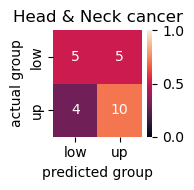

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
mat = pat_df.groupby(
    ['group', 'pred_group'])['pat'].count().reset_index().pivot(index='group', columns='pred_group', values='pat')
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
ax.set_title('Head & Neck cancer')
fig.tight_layout()

In [100]:
print('done!')

done!


## Big model

In [18]:
name = '3_6_traj'
train_loader = up_vs_low_bagloader(use_groups=[group], use_patients=p1ts)
classifier = GatedAttention(branches=5)
loss_df = train_model(classifier, bag_loader=train_loader, 
                num_iter=50_000, lr=0.0001, device=device, fname=name, 
                save_model=True, seed=12341, plot=False,
                transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

iter: 49999; train loss: 0.24359971; train error: 0.00000000: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [03:00<00:00, 277.74it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_6_traj_model.pt


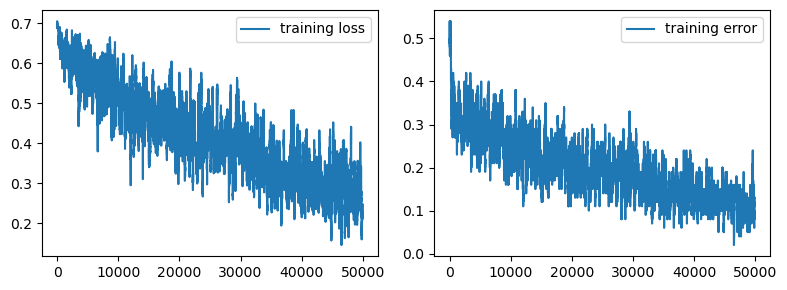

In [19]:
w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(loss_df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(loss_df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [34]:
name = '3_6_traj'
test_loader = test_up_vs_low_bagloader(use_groups=[group], use_patients=p1ts, return_chrometric=True)
res_df, zs, imgs, masks, chrometrics = eval_model_with_chrometric(name, test_loader) 
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4
0,1,1.0,0,P100,up,0.016105,0.011572,0.025414,0.009037,0.020959,2.286804,-0.205112,2.360424,0.266198,-0.351633
1,1,1.0,0,P100,up,0.014869,0.011113,0.020541,0.009693,0.018901,2.206977,-0.245575,2.147537,0.336274,-0.454995
2,1,1.0,0,P100,up,0.015447,0.015402,0.038947,0.006283,0.030941,2.245100,0.080753,2.787338,-0.097379,0.037867
3,1,1.0,0,P100,up,0.042048,0.028205,0.011721,0.007440,0.019023,3.246511,0.685768,1.586497,0.071659,-0.448553
4,1,1.0,0,P100,up,0.011792,0.017830,0.030480,0.006200,0.030102,1.975103,0.227156,2.542209,-0.110602,0.010378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,1,1.0,263,P98,up,0.001878,0.002416,0.000661,0.055654,0.001910,0.375676,-1.705533,-0.441398,1.819970,-2.537554
13196,1,1.0,263,P98,up,0.018955,0.019726,0.042034,0.004782,0.037440,2.687354,0.394195,3.710623,-0.634314,0.437854
13197,1,1.0,263,P98,up,0.010112,0.004636,0.004638,0.034500,0.007031,2.059053,-1.053768,1.506422,1.341767,-1.234568
13198,1,1.0,263,P98,up,0.000803,0.003154,0.000671,0.038173,0.001951,-0.474696,-1.439041,-0.427170,1.442962,-2.516472


In [35]:
(res_df['pred'] == res_df['lab']).mean()

0.9053030303030303

In [36]:
np.random.seed(1234)
# vis_idx = np.random.choice(np.arange(len(res_df)), replace=False, size=5000)
vis_idx = np.arange(len(res_df))
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(zs)[vis_idx])

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


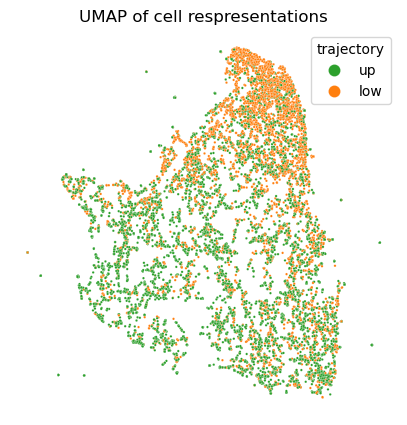

In [37]:
res_df.loc[res_df['umap_y'] > 15, 'umap_y'] = np.nan
res_df.loc[res_df['umap_y'] < -5, 'umap_y'] = np.nan
res_df.loc[res_df['lab'] == 1, 'trajectory'] = 'up'
res_df.loc[res_df['lab'] == 0, 'trajectory'] = 'low'

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='trajectory', s=3, ax=ax, palette={'up' : '#2ca02c', 'low' : '#ff7f0e'})
ax.set_title('UMAP of cell respresentations')
sns.move_legend(ax, 'best', markerscale=5)
ax.axis('off');

In [38]:
res_df['total attention'] = res_df['attention 0'] + res_df['attention 1'] + res_df['attention 2'] + res_df['attention 3']  +res_df['attention 4']
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4,umap_x,umap_y,trajectory,total attention
0,1,1.0,0,P100,up,0.016105,0.011572,0.025414,0.009037,0.020959,2.286804,-0.205112,2.360424,0.266198,-0.351633,3.020185,-0.332070,up,0.083087
1,1,1.0,0,P100,up,0.014869,0.011113,0.020541,0.009693,0.018901,2.206977,-0.245575,2.147537,0.336274,-0.454995,3.308732,0.403350,up,0.075118
2,1,1.0,0,P100,up,0.015447,0.015402,0.038947,0.006283,0.030941,2.245100,0.080753,2.787338,-0.097379,0.037867,5.255735,-2.180162,up,0.107019
3,1,1.0,0,P100,up,0.042048,0.028205,0.011721,0.007440,0.019023,3.246511,0.685768,1.586497,0.071659,-0.448553,14.794112,-1.958501,up,0.108437
4,1,1.0,0,P100,up,0.011792,0.017830,0.030480,0.006200,0.030102,1.975103,0.227156,2.542209,-0.110602,0.010378,5.786129,2.814887,up,0.096404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,1,1.0,263,P98,up,0.001878,0.002416,0.000661,0.055654,0.001910,0.375676,-1.705533,-0.441398,1.819970,-2.537554,-0.125064,4.831141,up,0.062520
13196,1,1.0,263,P98,up,0.018955,0.019726,0.042034,0.004782,0.037440,2.687354,0.394195,3.710623,-0.634314,0.437854,13.206737,-0.920420,up,0.122936
13197,1,1.0,263,P98,up,0.010112,0.004636,0.004638,0.034500,0.007031,2.059053,-1.053768,1.506422,1.341767,-1.234568,0.713280,2.623394,up,0.060917
13198,1,1.0,263,P98,up,0.000803,0.003154,0.000671,0.038173,0.001951,-0.474696,-1.439041,-0.427170,1.442962,-2.516472,7.666783,5.491132,up,0.044752


In [39]:
correct_low_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['trajectory'] == 'low')]['i'].unique()
correct_low_bags

array([ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  77,  78,  79,  80,  81,  82,
        83,  84,  85,  86,  87,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 154, 155, 156,
       157, 158, 159, 160, 161, 164, 176, 177, 184, 185, 198, 199, 201,
       202, 203, 206, 207, 208])

In [40]:
correct_up_bags = res_df[(res_df['lab'] == res_df['pred']) & (res_df['trajectory'] == 'up')]['i'].unique()
correct_up_bags

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  33,  34,
        35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,
        48,  49,  50,  51,  52,  53,  54,  57,  59,  61,  62,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  89,  92,
        94,  96,  97, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263])

In [45]:
img_array = np.array(imgs).reshape((264, 50, 1, 28, 28))
mask_array = np.array(masks).reshape((264, 50, 1, 28, 28))
img_array.shape

(264, 50, 1, 28, 28)

In [46]:
idx = res_df[res_df['i'] == 109]['total attention'].argsort().values[-3:]  # take last 3
res_df[res_df['i'] == 109].iloc[idx]['total attention']

5471    0.221998
5477    0.227998
5478    0.252805
Name: total attention, dtype: float32

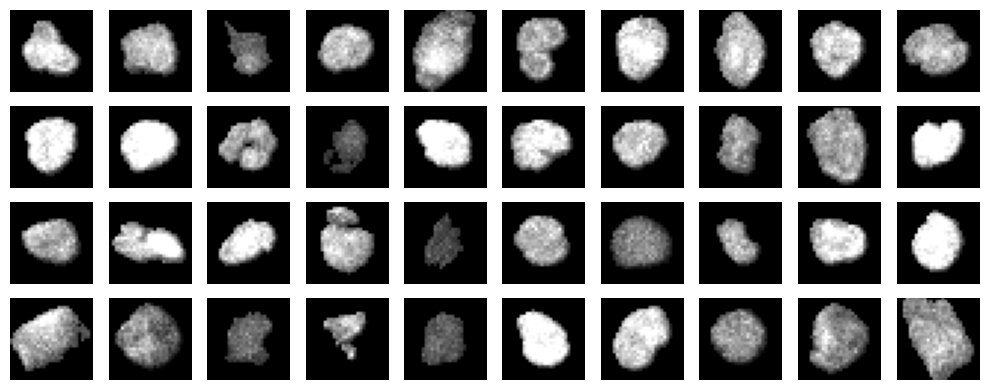

In [47]:
top_up_imgs = []
top_up_masks = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_up_imgs.extend(img_array[i, idx])
    top_up_masks.extend(mask_array[i, idx])
top_up_imgs = np.array(top_up_imgs)
top_up_masks = np.array(top_up_masks)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_up_imgs)), replace=False, size=40)
for im, m, ax in zip(top_up_imgs[show_idx], top_up_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

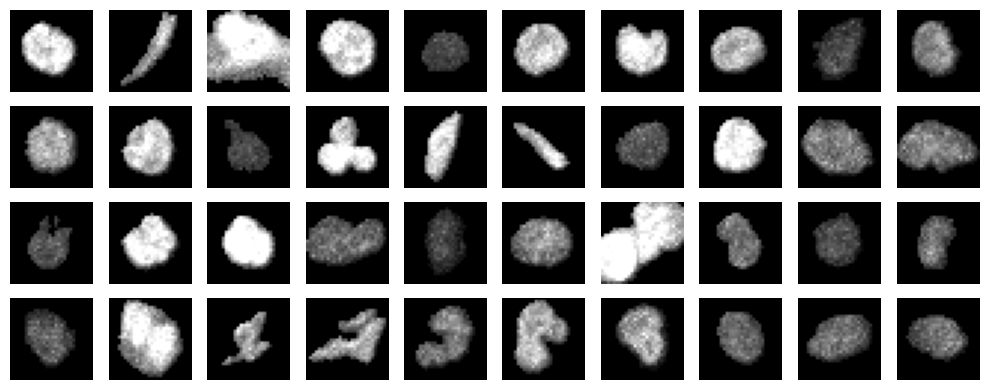

In [48]:
top_low_imgs = []
top_low_masks = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_low_imgs.extend(img_array[i, idx])
    top_low_masks.extend(mask_array[i, idx])
top_low_imgs = np.array(top_low_imgs)
top_low_masks = np.array(top_low_masks)

np.random.seed(51313)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_idx = np.random.choice(np.arange(len(top_low_imgs)), replace=False, size=40)
for im, m, ax in zip(top_low_imgs[show_idx], top_low_masks[show_idx], axxs.flatten()):
    ax.imshow((im * m).squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

In [50]:
res_df['failure patient'] = res_df['pat']
res_df.loc[~res_df['pat'].isin(['P18', 'P72', 'P125']), 'failure patient'] = 'No'

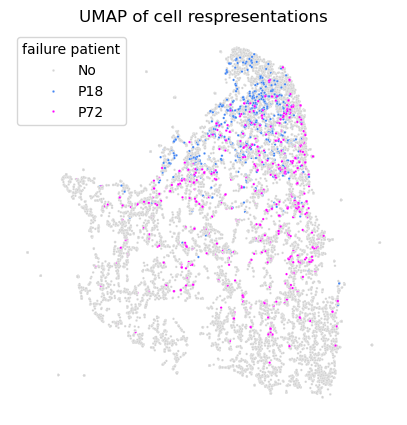

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='failure patient', s=3, ax=ax,
                palette={'No' : '#D3D3D3', 'P72' : '#FF00FF', 'P18' : '#4285f4'}, hue_order=['No', 'P18', 'P72'])
ax.set_title('UMAP of cell respresentations')
# sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
ax.axis('off');

### compare chrometric features for up vs. low

In [52]:
res_df

,lab,pred,i,pat,group,attention 0,attention 1,attention 2,attention 3,attention 4,raw attention 0,raw attention 1,raw attention 2,raw attention 3,raw attention 4,umap_x,umap_y,trajectory,total attention,failure patient
0,1,1.0,0,P100,up,0.016105,0.011572,0.025414,0.009037,0.020959,2.286804,-0.205112,2.360424,0.266198,-0.351633,3.020185,-0.332070,up,0.083087,No
1,1,1.0,0,P100,up,0.014869,0.011113,0.020541,0.009693,0.018901,2.206977,-0.245575,2.147537,0.336274,-0.454995,3.308732,0.403350,up,0.075118,No
2,1,1.0,0,P100,up,0.015447,0.015402,0.038947,0.006283,0.030941,2.245100,0.080753,2.787338,-0.097379,0.037867,5.255735,-2.180162,up,0.107019,No
3,1,1.0,0,P100,up,0.042048,0.028205,0.011721,0.007440,0.019023,3.246511,0.685768,1.586497,0.071659,-0.448553,14.794112,-1.958501,up,0.108437,No
4,1,1.0,0,P100,up,0.011792,0.017830,0.030480,0.006200,0.030102,1.975103,0.227156,2.542209,-0.110602,0.010378,5.786129,2.814887,up,0.096404,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,1,1.0,263,P98,up,0.001878,0.002416,0.000661,0.055654,0.001910,0.375676,-1.705533,-0.441398,1.819970,-2.537554,-0.125064,4.831141,up,0.062520,No
13196,1,1.0,263,P98,up,0.018955,0.019726,0.042034,0.004782,0.037440,2.687354,0.394195,3.710623,-0.634314,0.437854,13.206737,-0.920420,up,0.122936,No
13197,1,1.0,263,P98,up,0.010112,0.004636,0.004638,0.034500,0.007031,2.059053,-1.053768,1.506422,1.341767,-1.234568,0.713280,2.623394,up,0.060917,No
13198,1,1.0,263,P98,up,0.000803,0.003154,0.000671,0.038173,0.001951,-0.474696,-1.439041,-0.427170,1.442962,-2.516472,7.666783,5.491132,up,0.044752,No


In [53]:
chrometrics

,index,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,moments_central-3-1,moments_central-3-2,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6
0,25089,16,18,0.888889,6.237932,8.657403,7.642759,7.549597,6.237932,7.141623,...,649.826209,-24487.152842,5.647062e+04,0.161353,0.000300,0.000075,9.064168e-08,-2.069462e-13,-1.507405e-09,1.130550e-13
1,25124,15,19,0.789474,6.142125,8.959861,7.686335,7.557384,6.142125,6.911668,...,-5360.952070,-644.973341,2.373437e+03,0.164165,0.001149,0.000010,2.536991e-07,-1.630698e-13,-8.285543e-09,3.744486e-13
2,25111,15,24,0.625000,6.663843,12.783742,8.053265,8.550881,6.663843,7.479391,...,25460.968737,19006.042531,1.572136e+06,0.174896,0.002861,0.000122,1.623373e-05,6.558488e-10,7.439558e-07,3.048721e-10
3,25041,16,22,0.727273,6.321384,10.848064,9.006756,8.825907,6.321384,7.814944,...,-72639.310149,145849.789288,-2.387860e+06,0.169035,0.002022,0.000248,2.786347e-06,3.807391e-11,7.134705e-08,6.251323e-11
4,25163,14,21,0.666667,5.757487,10.351264,7.310010,7.702035,5.757487,6.743030,...,18127.128370,50693.878160,7.290005e+05,0.174078,0.003300,0.000395,8.143128e-06,-7.190965e-11,-1.418816e-07,4.560674e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,53071,11,14,0.785714,3.241145,6.783045,5.467865,5.335089,6.414817,4.701177,...,3924.437092,-2212.209153,3.292134e+04,0.171540,0.000577,0.000503,9.315508e-06,-1.461278e-10,2.133212e-07,-6.209787e-10
13196,53061,17,20,0.850000,7.192867,9.449349,8.380770,8.374488,7.192867,8.050335,...,2091.777057,29302.641694,1.739177e+04,0.160546,0.000143,0.000042,1.746639e-08,7.609001e-15,2.533678e-11,1.296998e-14
13197,53347,11,16,0.687500,4.392050,7.622506,5.852109,5.946583,4.392050,5.494101,...,-4869.582031,6643.769028,-7.421917e+04,0.167839,0.001639,0.000294,6.357668e-06,3.722712e-12,-1.005403e-07,2.746090e-10
13198,53259,9,16,0.562500,0.459304,9.070847,5.403522,5.409681,0.459304,3.982563,...,10609.040877,-19469.964169,2.071709e+05,0.282589,0.028733,0.003301,5.654050e-04,-3.082781e-07,-6.035431e-05,-7.082928e-07


In [54]:
chrometrics[chrometrics.drop(columns='index').isna().all(axis=1)]

,index,min_calliper,max_calliper,smallest_largest_calliper,min_radius,max_radius,med_radius,avg_radius,mode_radius,d25_radius,...,moments_central-3-1,moments_central-3-2,moments_central-3-3,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6


In [55]:
from scipy import stats

ps = []
for col in chrometrics.columns[1:]:
    ps.append(stats.kstest(chrometrics.loc[res_df['lab'] == 0, col].values, 
                           chrometrics.loc[res_df['lab'] == 1, col].values).pvalue)
ps = np.array(ps)
order = np.argsort(ps)
print((ps < 0.05).sum())
ps[order]

173


array([1.50740610e-239, 7.18118023e-224, 1.22389626e-217, 4.08084313e-216,
       3.90471403e-207, 6.14272655e-194, 1.08961271e-178, 9.27480474e-177,
       1.56397344e-161, 1.95490408e-145, 4.54103915e-143, 5.29071794e-143,
       1.52160007e-136, 1.13645565e-135, 3.19573702e-134, 1.12175070e-133,
       1.58831270e-132, 3.70753220e-131, 3.70753220e-131, 3.07376811e-130,
       1.25429995e-127, 2.23153404e-127, 3.43628865e-127, 6.56225228e-127,
       1.34542707e-126, 8.66394985e-126, 5.03111594e-124, 1.09800323e-123,
       1.09800323e-123, 1.09800323e-123, 1.09800323e-123, 1.45792855e-123,
       4.85677211e-123, 1.85822280e-122, 3.59392106e-120, 8.12932150e-118,
       1.14859814e-117, 1.15405778e-115, 2.13707211e-115, 2.13707211e-115,
       7.92854990e-114, 9.09712860e-113, 4.52413792e-111, 1.36935993e-109,
       9.36188456e-105, 1.90990749e-101, 2.07658608e-098, 2.07658608e-098,
       4.71056423e-098, 5.80062802e-097, 1.02266378e-095, 1.95401091e-093,
       3.60956197e-093, 9

In [57]:
cnt = []
for col in chrometrics.columns[1:]:
    cnt.append((chrometrics.loc[res_df['lab'] == 0, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 0, col]), 
                chrometrics.loc[res_df['lab'] == 1, col].isna().sum(), len(chrometrics.loc[res_df['lab'] == 1, col].isna())))
cnt = pd.DataFrame(cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])
cnt

,lab 0 nan,lab 0 cnt,lab 1 nan,lab 1 cnt
min_calliper,0,5500,0,7700
max_calliper,0,5500,0,7700
smallest_largest_calliper,0,5500,0,7700
min_radius,0,5500,0,7700
max_radius,0,5500,0,7700
...,...,...,...,...
moments_hu-2,0,5500,0,7700
moments_hu-3,0,5500,0,7700
moments_hu-4,0,5500,0,7700
moments_hu-5,0,5500,0,7700


In [58]:
nan_cnt = cnt[(cnt['lab 0 nan'] != 0) | (cnt['lab 1 nan'] != 0)]
bad_cols = nan_cnt.index
nan_cnt

,lab 0 nan,lab 0 cnt,lab 1 nan,lab 1 cnt
max_neg_curv,110,5500,168,7700
avg_neg_curv,110,5500,168,7700
med_neg_curv,110,5500,168,7700
std_neg_curv,110,5500,168,7700
sum_neg_curv,110,5500,168,7700
len_neg_curv,110,5500,168,7700
prominance_prominant_pos_curv,376,5500,742,7700
width_prominant_pos_curv,376,5500,742,7700
prominant_pos_curv,376,5500,742,7700
prominance_prominant_neg_curv,2308,5500,3906,7700


In [59]:
cnt['p-val'] = ps
cnt = cnt[~(cnt.index.isin(bad_cols))].sort_values('p-val')
cnt

,lab 0 nan,lab 0 cnt,lab 1 nan,lab 1 cnt,p-val
int_mean,0,5500,0,7700,1.507406e-239
int_d75,0,5500,0,7700,7.181180e-224
int_median,0,5500,0,7700,1.223896e-217
contrast_5,0,5500,0,7700,4.080843e-216
dissimilarity_5,0,5500,0,7700,3.904714e-207
...,...,...,...,...,...
dissimilarity_100,0,5500,0,7700,1.000000e+00
asm_100,0,5500,0,7700,1.000000e+00
correlation_100,0,5500,0,7700,1.000000e+00
contrast_100,0,5500,0,7700,1.000000e+00


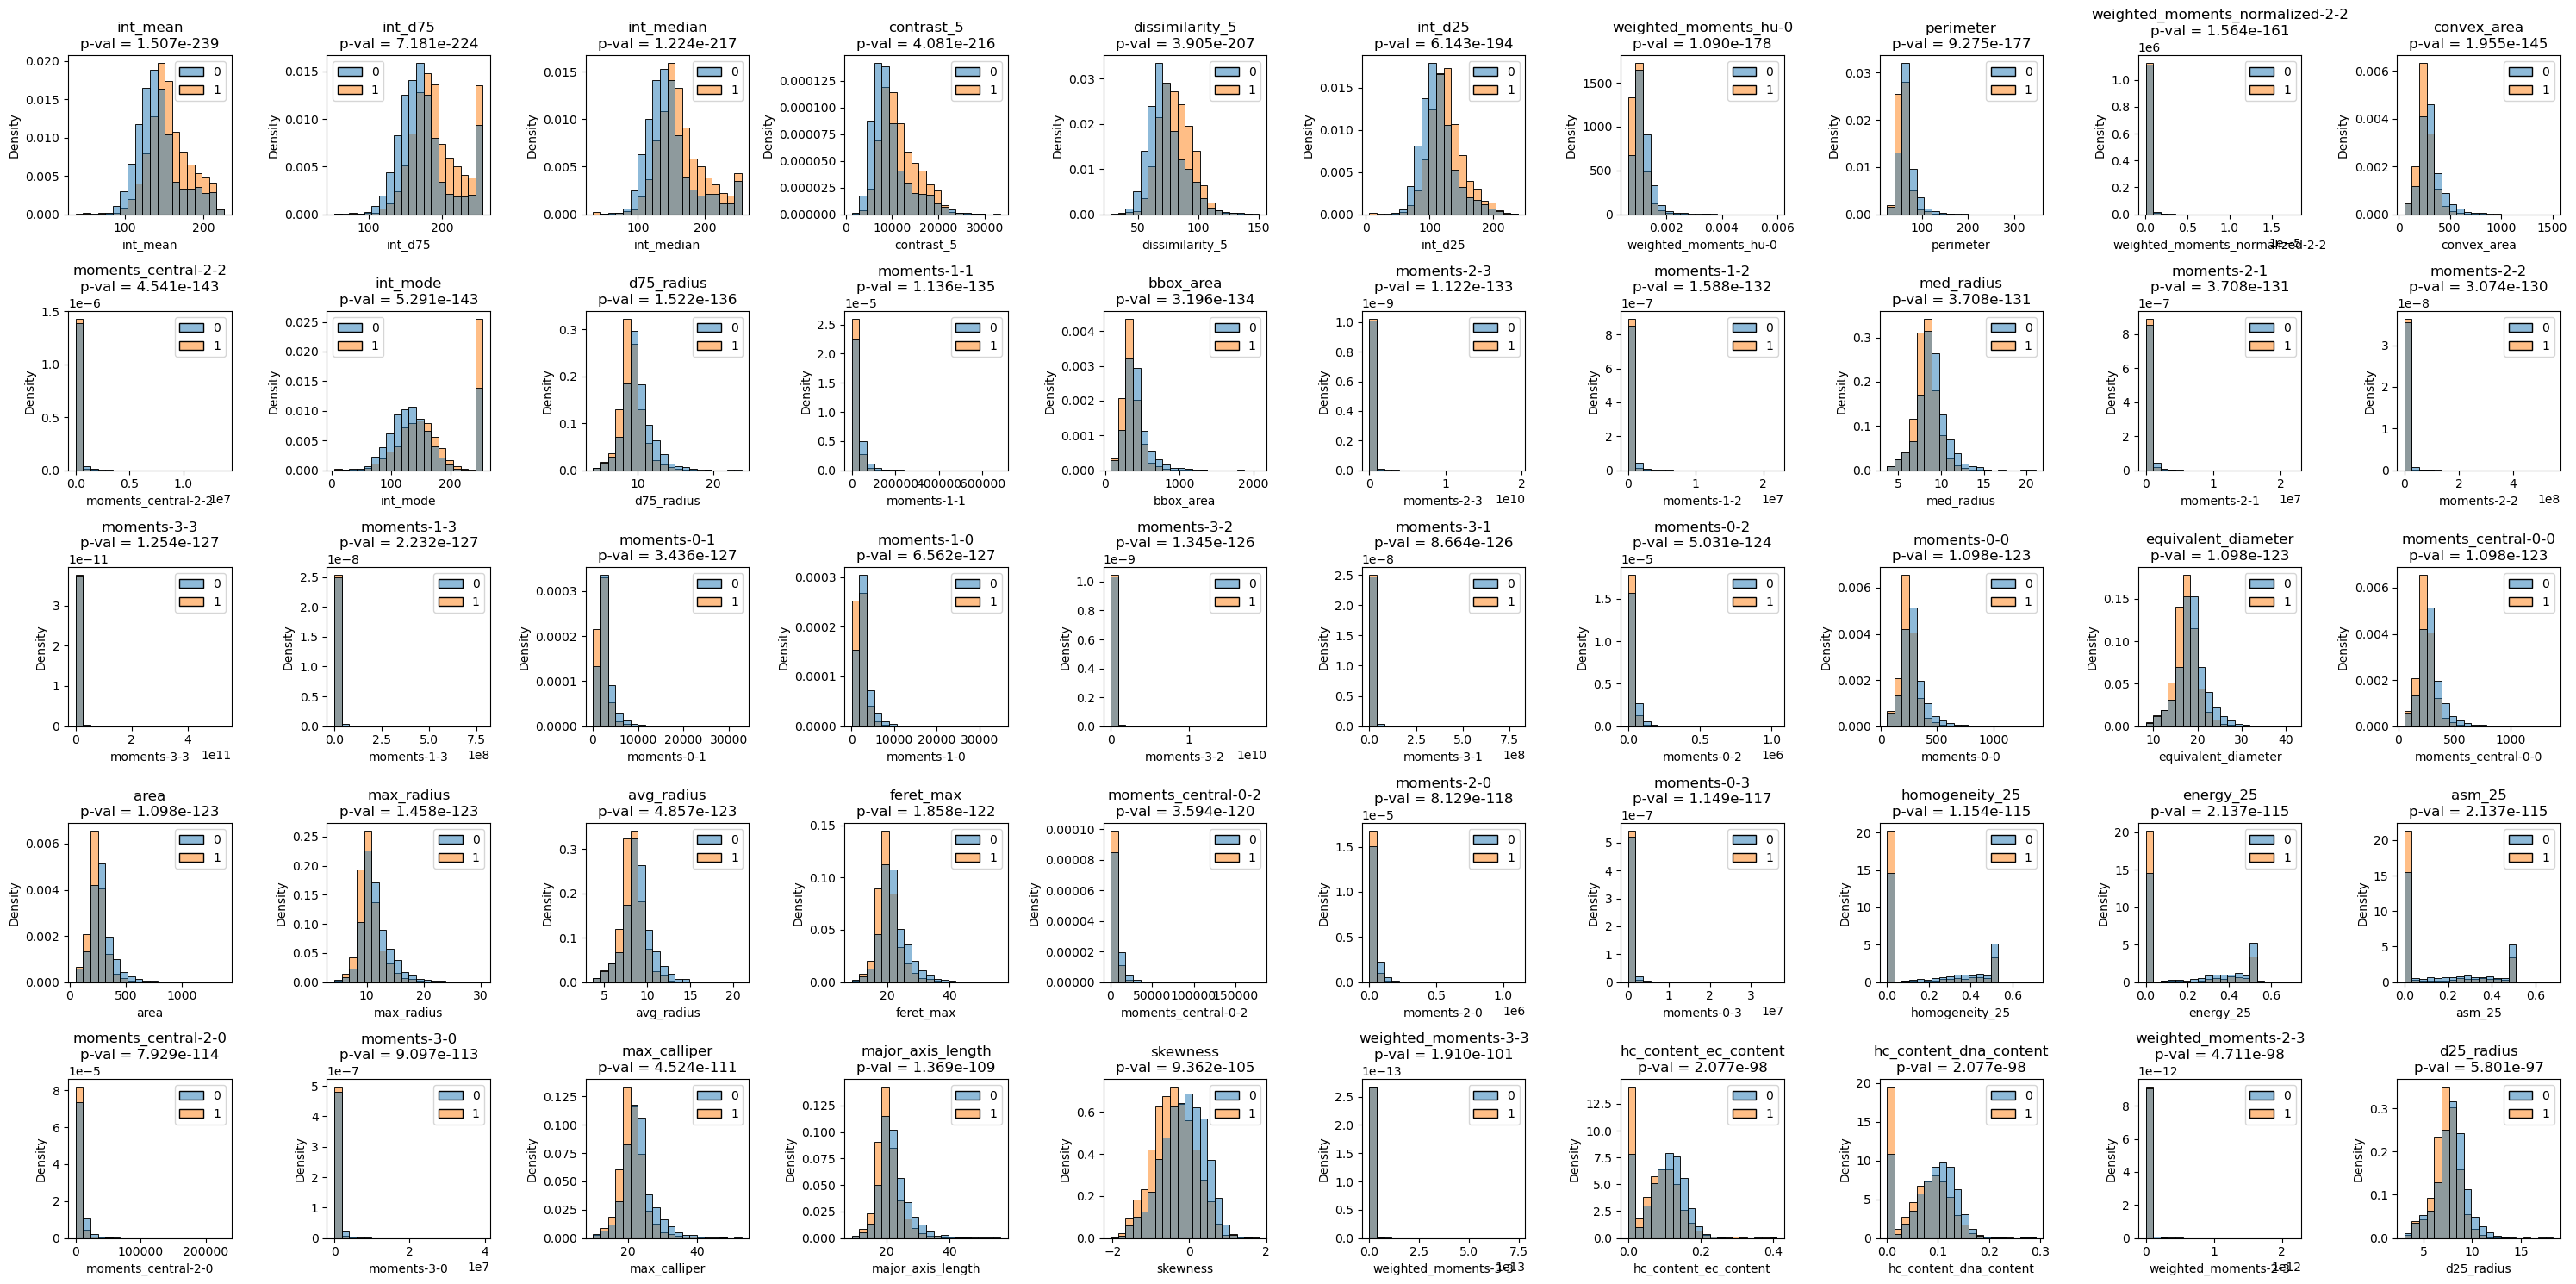

In [60]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), cnt.index):
    sns.histplot(data=chrometrics, x=col, hue=res_df['lab'].values, ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = cnt.loc[col, 'p-val']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

In [61]:
top_h_idx = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_h_idx.append(i * 50 + idx)
top_h_idx = np.concatenate(top_h_idx)

top_c_idx = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[-3:]  # take last 3
    top_c_idx.append(i * 50 + idx)
top_c_idx = np.concatenate(top_c_idx)

In [62]:
top_cnt = []
for col in chrometrics.columns[1:]:
    top_cnt.append((chrometrics.loc[top_c_idx, col].isna().sum(), len(chrometrics.loc[top_c_idx, col]), 
                    chrometrics.loc[top_h_idx, col].isna().sum(), len(chrometrics.loc[top_h_idx, col].isna())))
top_cnt = pd.DataFrame(top_cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])

top_ps = []
for col in chrometrics.columns[1:]:
    top_ps.append(stats.kstest(chrometrics.loc[top_h_idx, col].values, chrometrics.loc[top_c_idx, col].values).pvalue)
top_ps = np.array(top_ps)
top_cnt['p-val'] = top_ps
top_cnt = top_cnt[~(top_cnt.index.isin(bad_cols))].sort_values('p-val')
top_cnt

,lab 0 nan,lab 0 cnt,lab 1 nan,lab 1 cnt,p-val
int_mean,0,288,0,429,7.609888e-30
int_d75,0,288,0,429,4.990569e-29
int_mode,0,288,0,429,2.015118e-24
int_median,0,288,0,429,2.270206e-24
weighted_moments_hu-0,0,288,0,429,3.866995e-23
...,...,...,...,...,...
correlation_100,0,288,0,429,1.000000e+00
contrast_100,0,288,0,429,1.000000e+00
num_prominant_neg_curv,0,288,0,429,1.000000e+00
asm_100,0,288,0,429,1.000000e+00


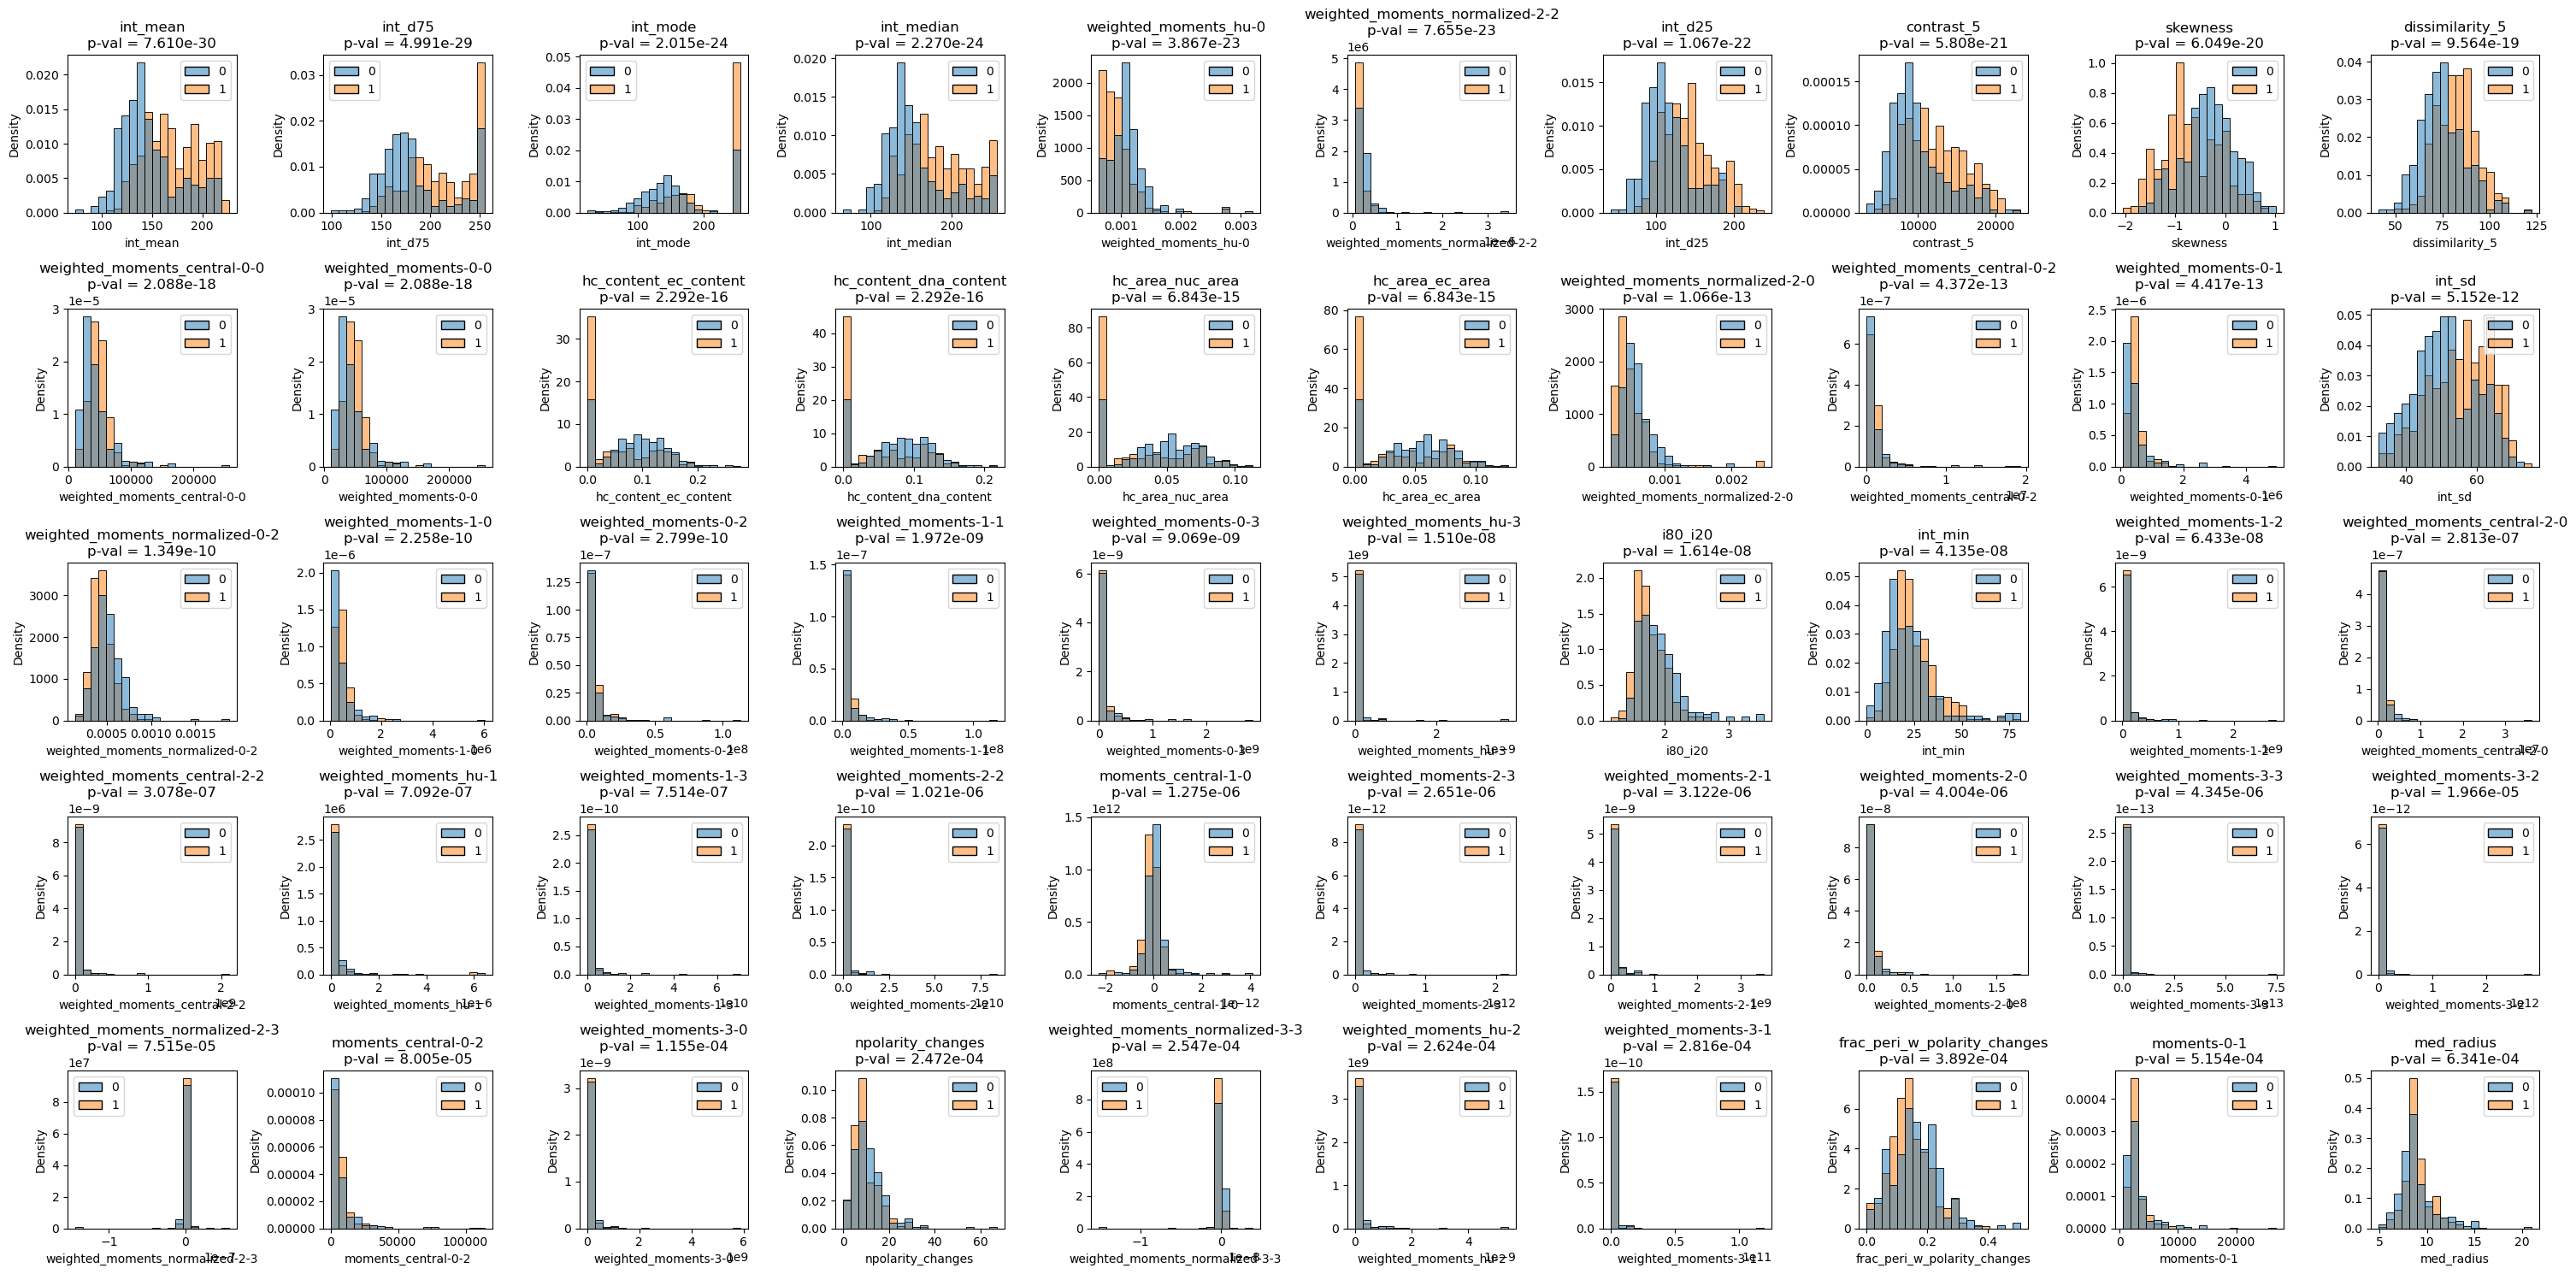

In [63]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), top_cnt.index):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_h_idx, top_c_idx))], x=col, 
                 hue=res_df.loc[np.concatenate((top_h_idx, top_c_idx)), 'lab'].values, ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = top_cnt.loc[col, 'p-val']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

In [64]:
print(chrometrics.columns.values[:100])

['index' 'min_calliper' 'max_calliper' 'smallest_largest_calliper'
 'min_radius' 'max_radius' 'med_radius' 'avg_radius' 'mode_radius'
 'd25_radius' 'd75_radius' 'std_radius' 'feret_max' 'centroid-0'
 'centroid-1' 'area' 'perimeter' 'bbox_area' 'convex_area'
 'equivalent_diameter' 'major_axis_length' 'minor_axis_length'
 'eccentricity' 'orientation' 'concavity' 'solidity' 'a_r' 'shape_factor'
 'area_bbarea' 'avg_curvature' 'std_curvature' 'npolarity_changes'
 'max_posi_curv' 'avg_posi_curv' 'med_posi_curv' 'std_posi_curv'
 'sum_posi_curv' 'len_posi_curv' 'max_neg_curv' 'avg_neg_curv'
 'med_neg_curv' 'std_neg_curv' 'sum_neg_curv' 'len_neg_curv'
 'num_prominant_pos_curv' 'prominance_prominant_pos_curv'
 'width_prominant_pos_curv' 'prominant_pos_curv' 'num_prominant_neg_curv'
 'prominance_prominant_neg_curv' 'width_prominant_neg_curv'
 'prominant_neg_curv' 'frac_peri_w_posi_curvature'
 'frac_peri_w_neg_curvature' 'frac_peri_w_polarity_changes' 'int_min'
 'int_d25' 'int_median' 'int_d75' 'i

In [65]:
print(chrometrics.columns.values[100:150])

['weighted_moments-2-0' 'weighted_moments-2-1' 'weighted_moments-2-2'
 'weighted_moments-2-3' 'weighted_moments-3-0' 'weighted_moments-3-1'
 'weighted_moments-3-2' 'weighted_moments-3-3'
 'weighted_moments_normalized-0-0' 'weighted_moments_normalized-0-1'
 'weighted_moments_normalized-0-2' 'weighted_moments_normalized-0-3'
 'weighted_moments_normalized-1-0' 'weighted_moments_normalized-1-1'
 'weighted_moments_normalized-1-2' 'weighted_moments_normalized-1-3'
 'weighted_moments_normalized-2-0' 'weighted_moments_normalized-2-1'
 'weighted_moments_normalized-2-2' 'weighted_moments_normalized-2-3'
 'weighted_moments_normalized-3-0' 'weighted_moments_normalized-3-1'
 'weighted_moments_normalized-3-2' 'weighted_moments_normalized-3-3'
 'weighted_moments_central-0-0' 'weighted_moments_central-0-1'
 'weighted_moments_central-0-2' 'weighted_moments_central-0-3'
 'weighted_moments_central-1-0' 'weighted_moments_central-1-1'
 'weighted_moments_central-1-2' 'weighted_moments_central-1-3'
 'weighte

In [66]:
print(chrometrics.columns.values[150:])

['moments-0-3' 'moments-1-0' 'moments-1-1' 'moments-1-2' 'moments-1-3'
 'moments-2-0' 'moments-2-1' 'moments-2-2' 'moments-2-3' 'moments-3-0'
 'moments-3-1' 'moments-3-2' 'moments-3-3' 'moments_normalized-0-0'
 'moments_normalized-0-1' 'moments_normalized-0-2'
 'moments_normalized-0-3' 'moments_normalized-1-0'
 'moments_normalized-1-1' 'moments_normalized-1-2'
 'moments_normalized-1-3' 'moments_normalized-2-0'
 'moments_normalized-2-1' 'moments_normalized-2-2'
 'moments_normalized-2-3' 'moments_normalized-3-0'
 'moments_normalized-3-1' 'moments_normalized-3-2'
 'moments_normalized-3-3' 'moments_central-0-0' 'moments_central-0-1'
 'moments_central-0-2' 'moments_central-0-3' 'moments_central-1-0'
 'moments_central-1-1' 'moments_central-1-2' 'moments_central-1-3'
 'moments_central-2-0' 'moments_central-2-1' 'moments_central-2-2'
 'moments_central-2-3' 'moments_central-3-0' 'moments_central-3-1'
 'moments_central-3-2' 'moments_central-3-3' 'moments_hu-0' 'moments_hu-1'
 'moments_hu-2' 'mom

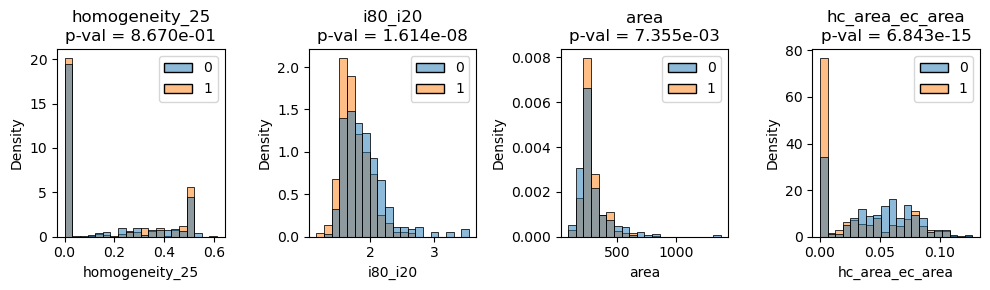

In [67]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_h_idx, top_c_idx))], x=col, 
                 hue=res_df.loc[np.concatenate((top_h_idx, top_c_idx)), 'lab'].values, ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = top_cnt.loc[col, 'p-val']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

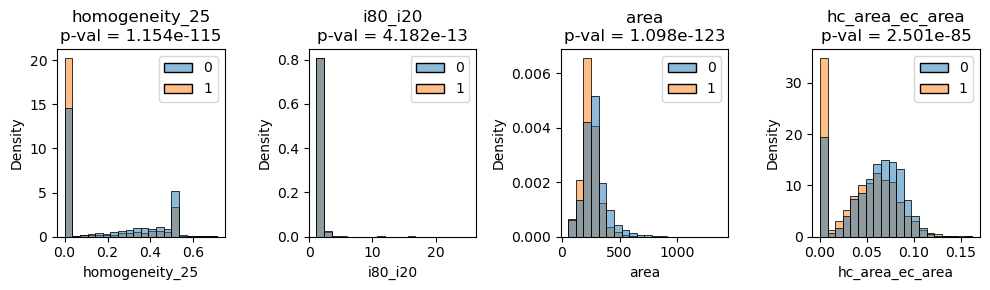

In [68]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics, x=col, 
                 hue=res_df['lab'].values, ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = cnt.loc[col, 'p-val']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

### compare chrometric features for high vs. low attention

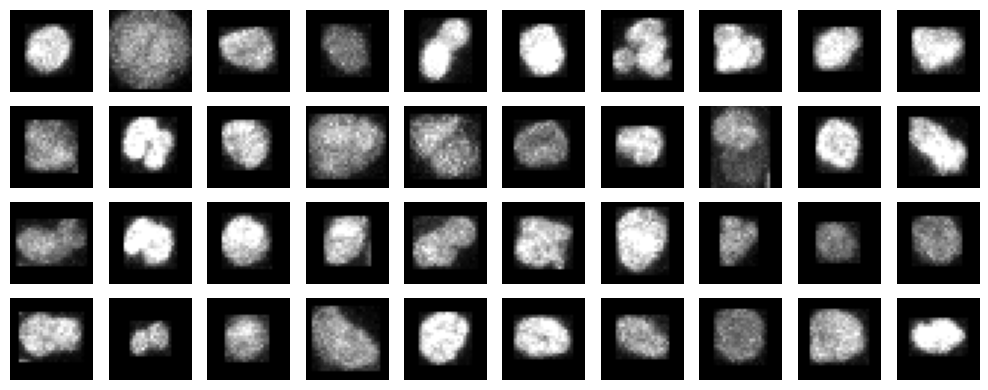

In [69]:
bot_up_imgs = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[3:]  # take first 3
    bot_up_imgs.extend(img_array[i, idx])
bot_up_imgs = np.array(bot_up_imgs)

np.random.seed(25323)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_imgs = bot_up_imgs[np.random.choice(np.arange(len(bot_up_imgs)), replace=False, size=40)]
for im, ax in zip(show_imgs, axxs.flatten()):
    ax.imshow(im.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

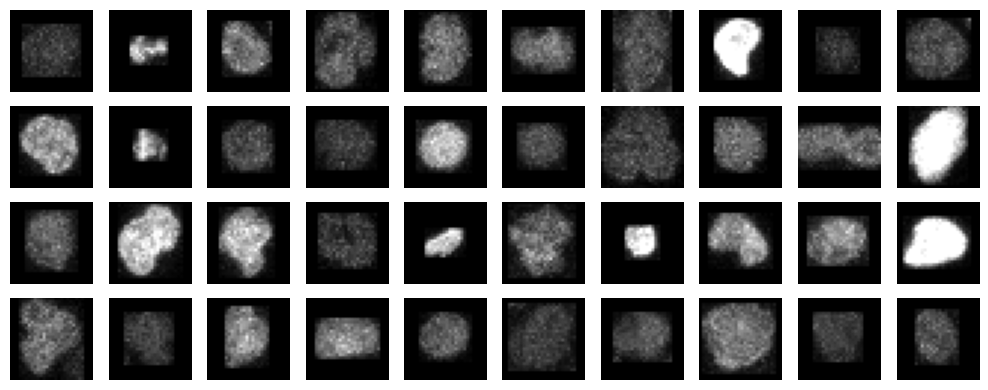

In [70]:
bot_low_imgs = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[3:]  # take first 3
    bot_low_imgs.extend(img_array[i, idx])
bot_low_imgs = np.array(bot_low_imgs)

np.random.seed(51313)
fig, axxs = plt.subplots(4, 10, figsize=(10, 4))
show_imgs = bot_low_imgs[np.random.choice(np.arange(len(bot_low_imgs)), replace=False, size=40)]
for im, ax in zip(show_imgs, axxs.flatten()):
    ax.imshow(im.squeeze(), cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
fig.tight_layout()
fig.show()

In [71]:
bot_h_idx = []
for i in correct_up_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_h_idx.append(i * 50 + idx)
bot_h_idx = np.concatenate(bot_h_idx)

bot_c_idx = []
for i in correct_low_bags:
    idx = res_df[res_df['i'] == i]['total attention'].argsort().values[:3]  # take first 3
    bot_c_idx.append(i * 50 + idx)
bot_c_idx = np.concatenate(bot_c_idx)

In [72]:
print(len(bot_c_idx), len(bot_h_idx), len(top_h_idx), len(top_c_idx))
m = min(len(bot_c_idx), len(bot_h_idx), len(top_h_idx), len(top_c_idx))

288 429 429 288


In [73]:
bot_cnt = []
for col in chrometrics.columns[1:]:
    bot_cnt.append((chrometrics.loc[bot_c_idx, col].isna().sum(), len(chrometrics.loc[bot_c_idx, col]), 
                    chrometrics.loc[bot_h_idx, col].isna().sum(), len(chrometrics.loc[bot_h_idx, col])))
bot_cnt = pd.DataFrame(bot_cnt, index=chrometrics.columns[1:], columns=['lab 0 nan', 'lab 0 cnt', 'lab 1 nan', 'lab 1 cnt'])

bot_ps_h = []
bot_ps_c = []
np.random.seed(5213)
for col in chrometrics.columns[1:]:
    bot_ps_h.append(stats.kstest(chrometrics.loc[np.random.choice(top_h_idx, size=m, replace=False), col].values, 
                                 chrometrics.loc[np.random.choice(bot_h_idx, size=m, replace=False), col].values).pvalue)
    bot_ps_c.append(stats.kstest(chrometrics.loc[np.random.choice(top_c_idx, size=m, replace=False), col].values, 
                                 chrometrics.loc[np.random.choice(bot_c_idx, size=m, replace=False), col].values).pvalue)
bot_ps_h = np.array(bot_ps_h)
bot_ps_c = np.array(bot_ps_c)
bot_cnt['p-val (up)'] = bot_ps_h
bot_cnt['p-val (low)'] = bot_ps_c
bot_cnt = bot_cnt[~(bot_cnt.index.isin(bad_cols))].sort_values('p-val (up)')
bot_cnt

,lab 0 nan,lab 0 cnt,lab 1 nan,lab 1 cnt,p-val (up),p-val (low)
weighted_moments-0-0,0,288,0,429,3.131215e-41,5.240203e-05
int_d75,0,288,0,429,1.273001e-39,1.444181e-14
weighted_moments_hu-0,0,288,0,429,4.291558e-39,8.522775e-16
hc_content_dna_content,0,288,0,429,1.432670e-38,1.475950e-25
avg_posi_curv,0,288,0,429,4.736366e-38,7.691069e-07
...,...,...,...,...,...,...
contrast_100,0,288,0,429,1.000000e+00,1.000000e+00
asm_100,0,288,0,429,1.000000e+00,1.000000e+00
dissimilarity_100,0,288,0,429,1.000000e+00,1.000000e+00
energy_100,0,288,0,429,1.000000e+00,1.000000e+00


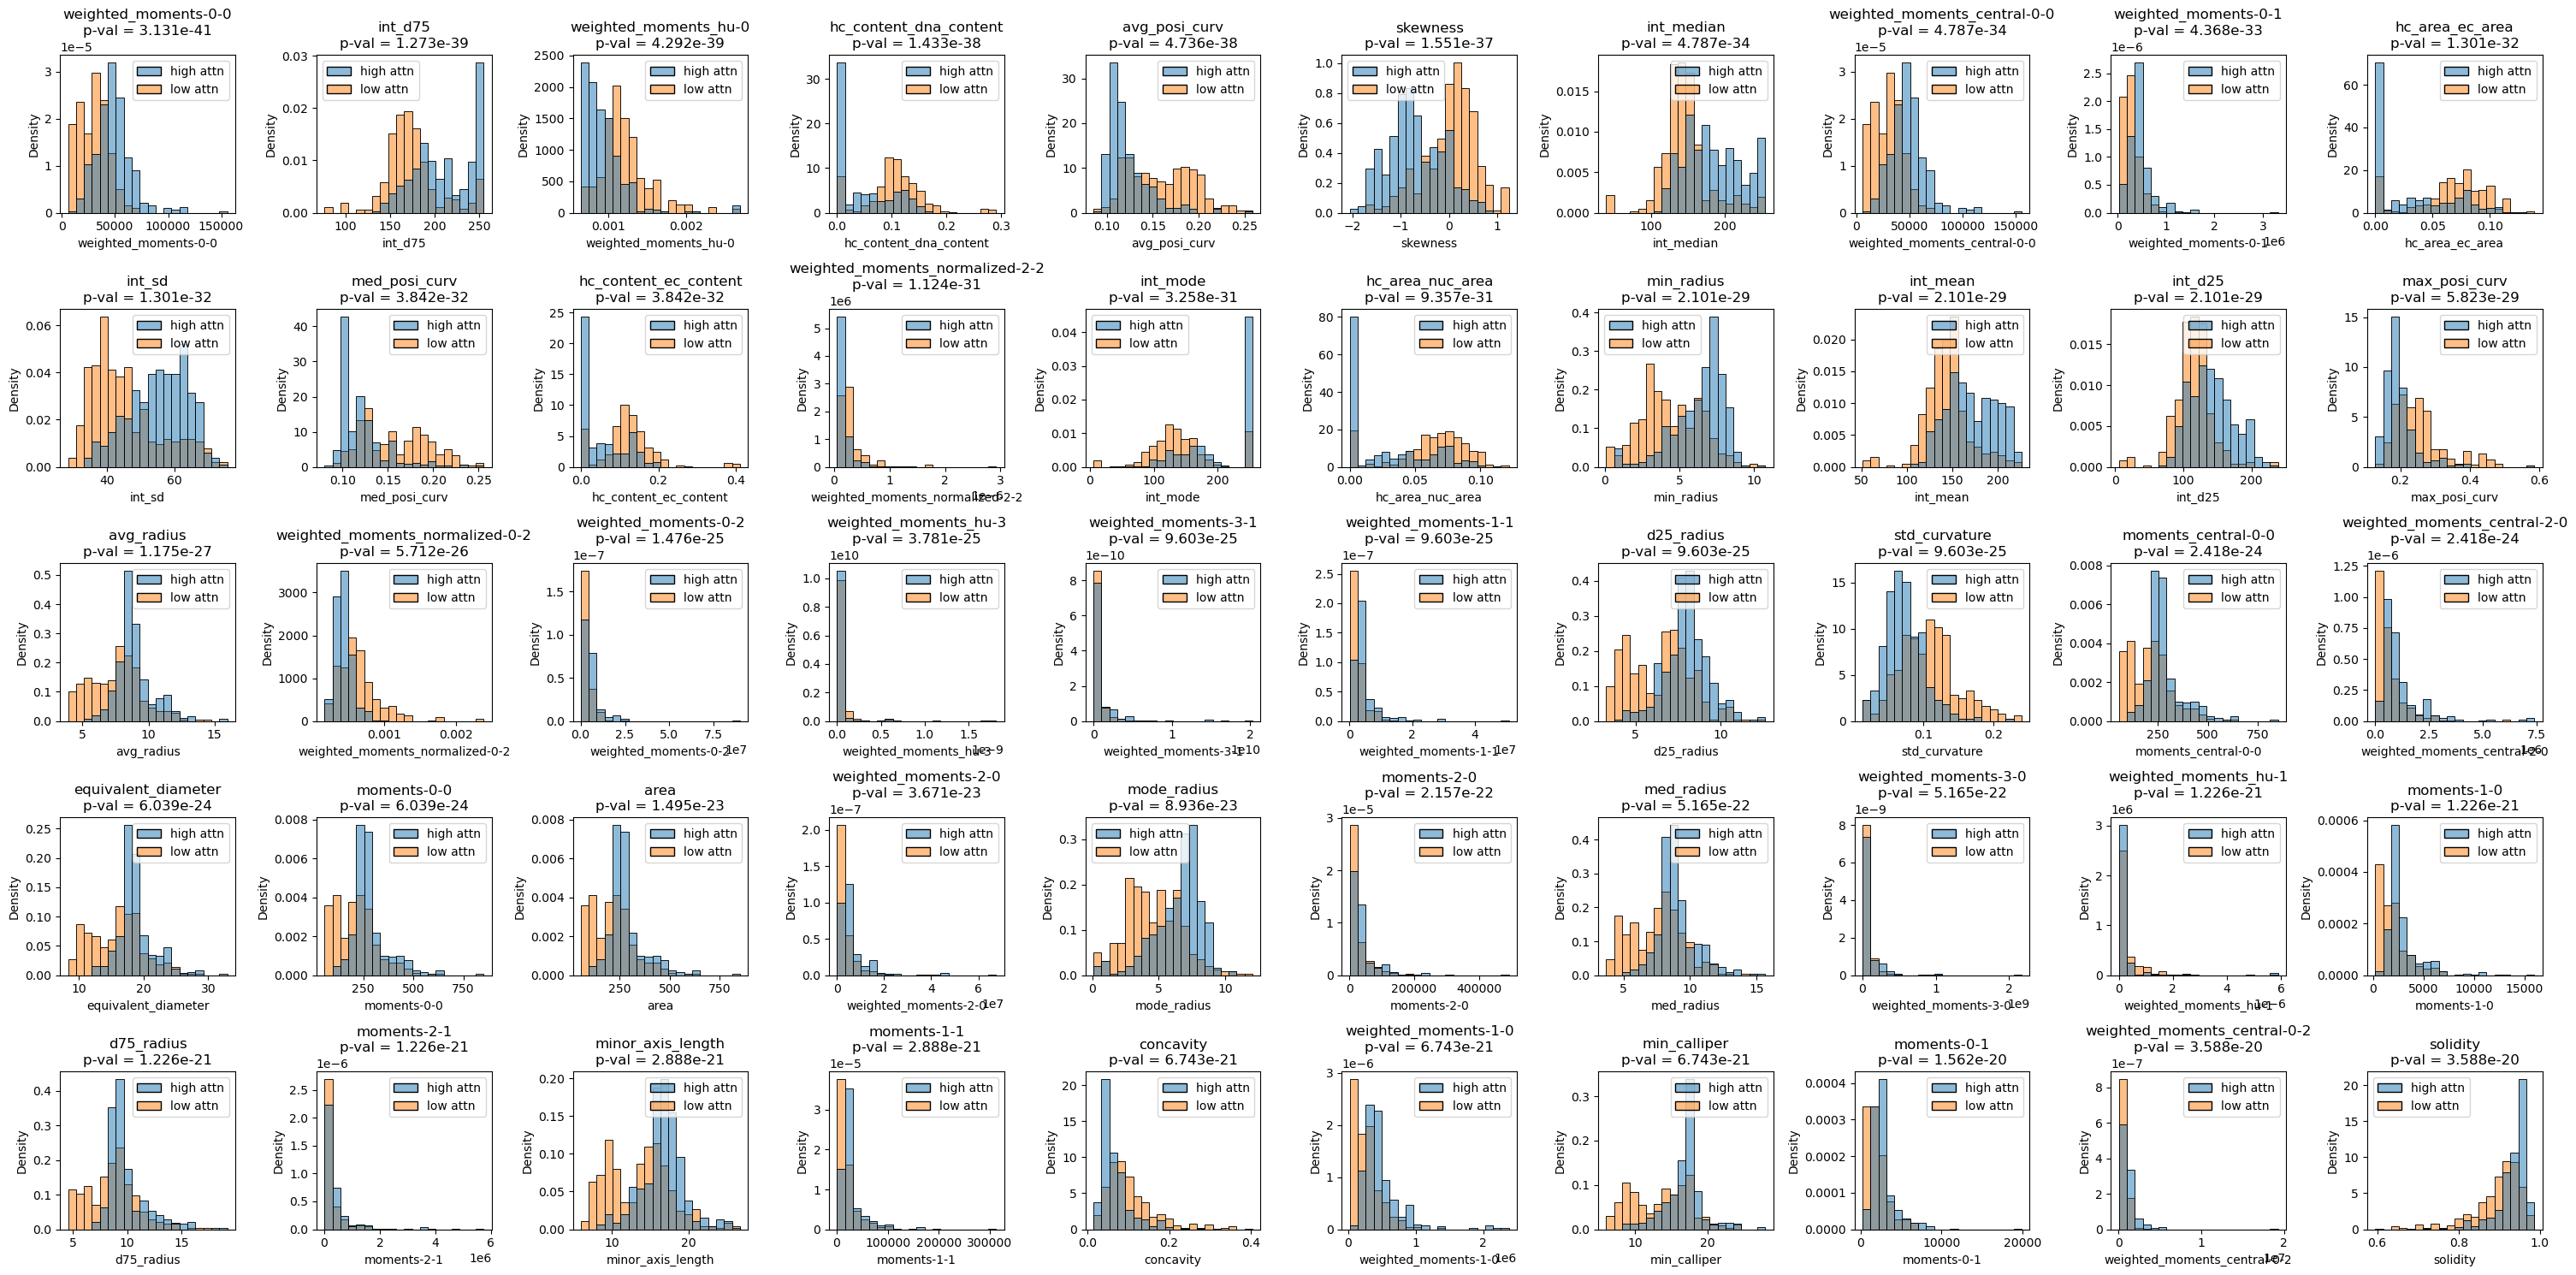

In [74]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), bot_cnt.sort_values('p-val (up)').index):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_h_idx, bot_h_idx))], x=col, 
                 hue=['high attn'] * len(top_h_idx) + ['low attn'] * len(bot_h_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (up)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

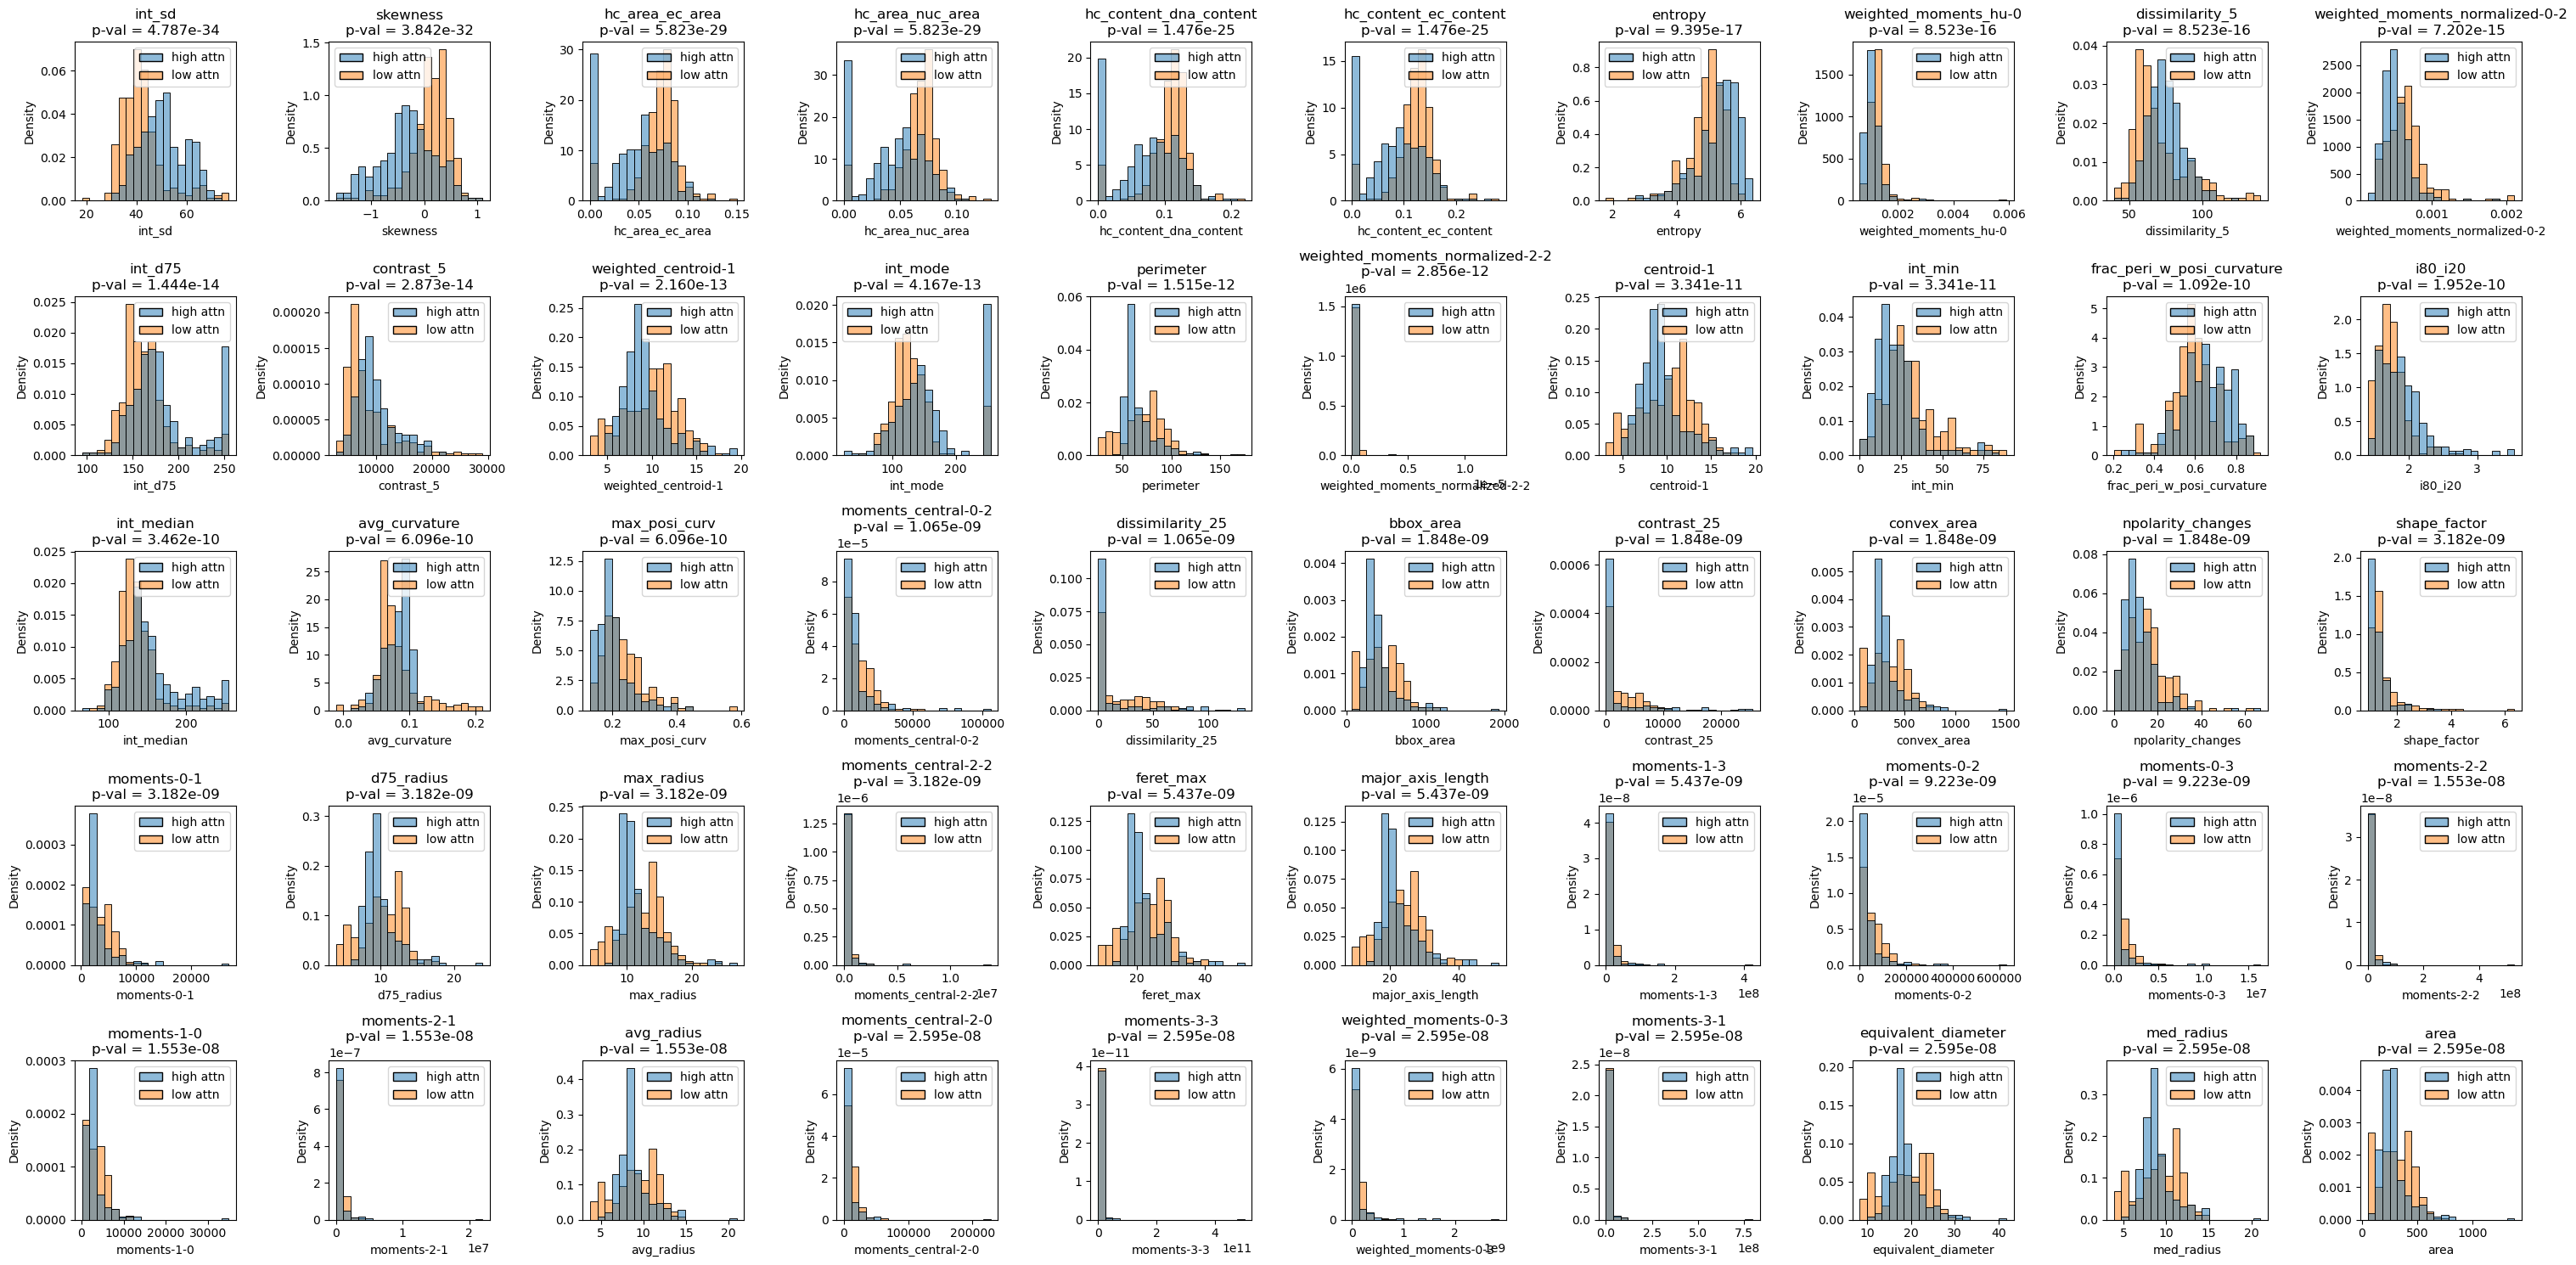

In [75]:
fig, axs = plt.subplots(5, 10, figsize=(30, 15))
for ax, col in zip(axs.flatten(), bot_cnt.sort_values('p-val (low)').index):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_c_idx, bot_c_idx))], x=col, 
                 hue=['high attn'] * len(top_c_idx) + ['low attn'] * len(bot_c_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (low)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

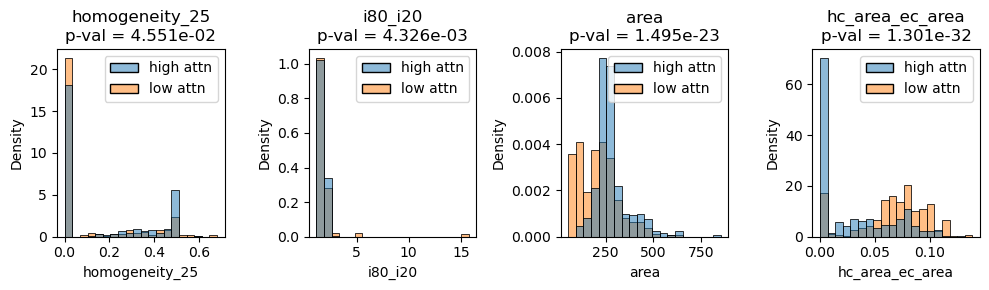

In [76]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_h_idx, bot_h_idx))], x=col, 
                 hue=['high attn'] * len(top_h_idx) + ['low attn'] * len(bot_h_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (up)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()

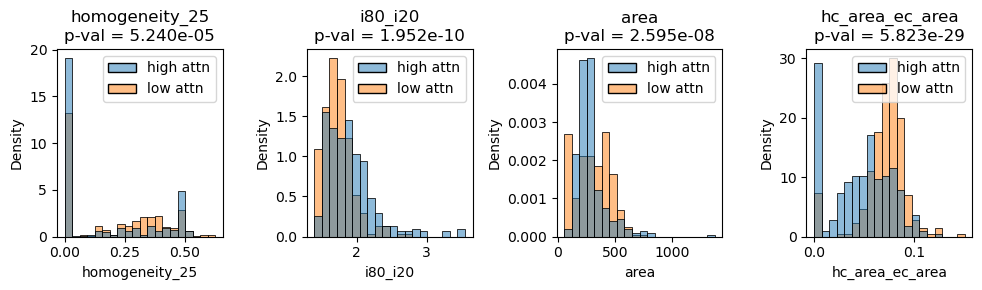

In [77]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
for ax, col in zip(axs.flatten(), ['homogeneity_25', 'i80_i20', 'area', 'hc_area_ec_area']):
    sns.histplot(data=chrometrics.loc[np.concatenate((top_c_idx, bot_c_idx))], x=col, 
                 hue=['high attn'] * len(top_c_idx) + ['low attn'] * len(bot_c_idx) , ax=ax, bins=20, 
                 common_norm=False, stat='density')
    p = bot_cnt.loc[col, 'p-val (low)']
    ax.set_title(f'{col}\np-val = {p:0.3e}')
fig.tight_layout()